---
## Setup

Import modules

In [1]:
import os
import sys
import io
import copy

from Bio import Phylo
import pandas as pd
import treetime

Input file paths

In [2]:
# Use branch support tree since the node names are fixed
tree_path = "../../docs/results/latest/branch_support/branch_support.nwk"
aln_path = "../../docs/results/latest/snippy_multi/snippy-core_chromosome.snps.filter5.aln"
tree_df_path = "../../docs/results/latest/mugration/mugration.tsv"
outdir = "../../docs/results/latest/timetree/"

# Create output directory if it doesn't exist
if not os.path.exists(outdir):
    os.mkdir(outdir)

Variables

In [3]:
# Data, columns, colors
NO_DATA_CHAR = "NA"
DATE_COL = "Date"
TERM_COL = "grey"

BRANCH_LEN_SIG_DIG = 12

# Relaxed clock parameters
# Slack around 1.0 correspond to weak priors, larger values constrain rate deviations more strongly.
# I'm pretty sure we want a weak prior, since the distribution of rate deviation is lognormal
slack = 1
# Coupling 0 (–relax 1.0 0) corresponds to an un-correlated clock.
coupling = 0
confidence = 0.95
# Offset for mutations: 0 will be 1-based
offset = 0

# Number of interquartile distances to identify outliers
n_iqd = 3

# Number of iterations 
max_iter = 3

# Branch Length Optimization
# For more divergent sequences, iterative optimization will underestimate the branch lengths
# What is "divergent"? treetime data is a lot of epidemic viral phylo, so I think bacterial history is divergent
# Shaw et al. (2019) finds that joint is inappropriate (because topology is fixed), classical marginal is fine?
bl_mode = "input"
ml_mode = "marginal" # Shaw et al. (2019) demonstrate joint is bad
title = "Uncorrelated Relaxed Clock"
file_prefix = "uncorrelated-relaxed-clock"

#present = datetime.date.today().year

#random.seed(131495)

# FIRST! Try to estimate clock rate from data. See how it compares to literature.
# For many bacterial data set were the temporal signal in the data is weak, 
# it is advisable to fix the rate of the molecular clock explicitly. 
# Divergence times, however, will depend on this choice
# Cui 2013 (cites Morelli 2010) contrains the mean to 1e-8
#clock_rate = 1e-8
# Spyrou et al. 2019 observed a rate variation from 2.09E–7 to 4.95E–9
# Mean substituion rate was 2.85E–8
# clock_rate = 2e-8

Read input tree and dataframe

In [4]:
tree_div = Phylo.read(tree_path, "newick")
tree_df = pd.read_csv(tree_df_path, sep='\t')
# Fix the problem with multiple forms of NA in the table
# Consolidate missing data to the NO_DATA_CHAR
tree_df.fillna(NO_DATA_CHAR, inplace=True)
tree_df.set_index("Name", inplace=True)

In [5]:
tree_div.common_ancestor("NODE0")

Clade(branch_length=0.0, name='NODE0')

Clade(branch_length=1.0000000000000006e-12, name='NODE0')

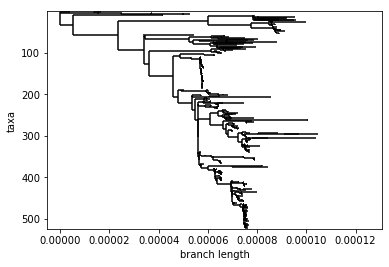

In [6]:
# Check to make sure tree looks good

# Reset the root branch length from 0 to smallest branch len possible
tree_div.root.branch_length = pow(0.1, BRANCH_LEN_SIG_DIG)

# Deepest nodes at top
tree_div.ladderize(reverse=False)
Phylo.draw(tree_div,
               show_confidence=False, 
               label_func = lambda x:'', 
               do_show=False)

tree_div.common_ancestor("NODE0")

In [7]:
# Select tips
dates_df = tree_df[tree_df["Branch_Support_Color"] == "grey"]
# Select only the date column
dates_df = dates_df[[DATE_COL]].copy()

# TEMPORARY
dates_df.at["Reference",DATE_COL] = 1992

# Save tree dataframe to a tmp file
tmp_tsv = os.path.join(outdir, "tmp.tsv" )
dates_df.to_csv(tmp_tsv, sep="\t")

Parse dates

In [8]:
dates = treetime.utils.parse_dates(tmp_tsv, date_col=DATE_COL)


Attempting to parse dates...
	Using column 'Name' as name. This needs match the taxon names in the tree!!
	Using column 'Date' as date.


---
## Timetree Analysis

In [9]:
# Basic initialize, fine tuning comes in next step
tt_relaxed = treetime.TreeTime(tree = tree_div,
                      aln = aln_path,
                      verbose = 4,
                      dates = dates,
                      branch_length_mode = bl_mode,
                      #one_mutation=0.00001,
                      )

# Fix the root lengths from arbitrary 
#tt_relaxed.tree.root.original_length = pow(0.1, BRANCH_LEN_SIG_DIG)
# Set to 0 instead
#tt_relaxed.tree.root.original_length = 0
#tt_relaxed.tree.root.branch_length = tt_relaxed.tree.root.original_length
#tt_relaxed.tree.root.mutation_length = tt_relaxed.tree.root.original_length

# Rerooting will reset the fixed branch lengths


0.00	-TreeAnc: set-up

0.52	-SequenceData: loaded alignment.

0.52	-SeqData: making compressed alignment...

1.01	-SequenceData: constructed compressed alignment...
1.11	--ClockTree: Setting precision to level 1

1.14	-ClockTree._assign_dates: assigned date contraints to 523 out of 523 tips.


## Troubleshooting

In [21]:
print(tt_relaxed.data.full_length)
print(tt_relaxed.one_mutation(5.0))

3810


TypeError: 'float' object is not callable

In [ ]:
# Check to make sure tree root still looks good...

# Deepest nodes at top
tt_relaxed.tree.ladderize(reverse=False)

Phylo.draw(tt_relaxed.tree,
               show_confidence=False, 
               label_func = lambda x:'', 
               do_show=False)


In [ ]:
for c in tt_relaxed.tree.find_clades():
    print(c.name, "\t", c.branch_length, "\t", c.dist2root, "\t", c.mutation_length, "\t", c.original_length)

In [ ]:
print("Running timetree analysis...")
# Initialize stdout capture
"""old_stdout = sys.stdout
new_stdout = io.StringIO()
sys.stdout = new_stdout"""

tt_relaxed.run(branch_length_mode = bl_mode,
               n_iqd=n_iqd,
               root=None,
               infer_gtr=True,
               resolve_polytomies=False,
               relaxed_clock={"slack":slack, "coupling":coupling},
               max_iter=max_iter,
               Tc="skyline",
               use_covariation=False,
               vary_rate=False,
               time_marginal="assign",
               sequence_marginal=True,
               verbose=4,
               #clock_rate = clock_rate,
              )

# Save stdout to file
"""output = new_stdout.getvalue()
out_path = os.path.join(outdir, "treetime.log") 
with open(out_path, "w") as file:
    file.write(output)
# Restore stdout
sys.stdout = old_stdout"""

print("Finished timetree analysis.")

Make a copy for testing

In [ ]:
tt_relaxed_copy = copy.deepcopy(tt_relaxed)

Make sure tree is as expected

In [ ]:
for c in tt_relaxed.tree.find_clades():
    print(c.name, "\t", c.branch_length, "\t", c.dist2root, "\t", c.mutation_length, "\t", c.original_length)

In [ ]:
# Check to make sure the root still looks good...

# Deepest nodes at top
tt_relaxed.tree.ladderize(reverse=False)

Phylo.draw(tt_relaxed.tree,
               show_confidence=False, 
               label_func = lambda x:'', 
               do_show=False)


Add node comments

In [ ]:
for c in tt_relaxed.tree.find_clades():
    """# Add mutations comment
    if c.mutations:
        mut_comment = 'mutations="' + ','.join([a+str(pos + offset)+d for (a,pos, d) in c.mutations
                                                              if tt_relaxed.gtr.ambiguous not in [a,d]])+'"'
        if c.comment:
            c.comment = ",".join([c.comment, mut_comment])
        else:
            c.comment = "&" + mut_comment
    # Add date comment
    if c.numdate:
        date_comment = 'date={:.2f}'.format(c.numdate)
        if c.comment:
            c.comment = ",".join([c.comment, date_comment])
        else:
            c.comment = "&" + date_comment"""
    
    # Add this info to the dataframe somehow...
    if c.name == "NODE0":
        print(c.name, c.numdate)

In [ ]:
Phylo.draw(tt_relaxed.tree,
               show_confidence=False, 
               label_func = lambda x:'', 
               do_show=False)

### Stats

---
## Cleanup

In [ ]:
os.remove(tmp_tsv)